# Dissertation Explanation and Exploration

This Notebook contains figures used in my dissertaition. Some to explain concepts and some to demonstrate my project

In [1]:
from Antenna import Antenna
from Array import Array
from Model import Model

import pandas as pd
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Vector 'closeness' explanation

This section contains the ideas and methods behind the core of the AOA algorithm

Before, we were inferring by antenna-pairs, comparing the difference of each antenna with another. For clarity's sake we refer to the middle antenna in the array as `AM`, the antenna in the +ve theta direction to that (counter-clockwise) is refered to as `AL (Antenna Left)`, because when the array is pointing towards theta = 0, that antenna is to the left. Likewise, the antenna in the clockwise (negative theta) direction, is refered to `AR (Antenna Right)`. If we were to take the gain of all the antenna in the array in the range $\theta=\{0,2\pi\}$, we would get the following gain pattern:

c:\Users\euan\OneDrive\Desktop\Dissertation Project\Angle Probability\Antenna.py:122: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(side_lobes,lobes_dB,190,rcond=0)
c:\Users\euan\OneDrive\Desktop\Dissertation Project\Angle Probability\Antenna.py:122: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(side_lobes,lobes_dB,190,rcond=0)
c:\Users\euan\OneDrive\Desktop\Dissertation Project\Angle Probability\Antenna.py:122: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(side_lobes,lobes_dB,190,rcond=0)


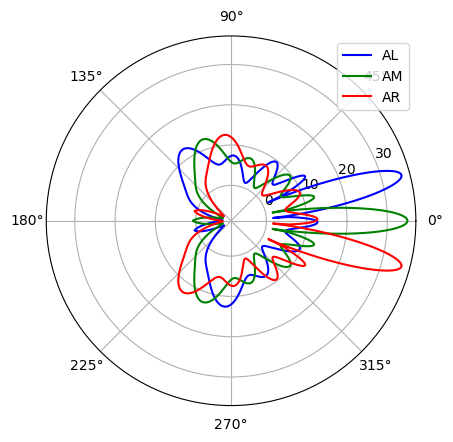

In [2]:
m = Model(np.pi/20,100,np.pi/12)
m.polar_plot(legend=True)

For the simplicity of explaining how the algorithm works, we will just consider the antennas AL and AM, and for further simplicity we will consider only the main lobe of the antenna which is given by the equation $r=gain_{amp}+gain_{base}*\cos(\theta)^a$, seen here

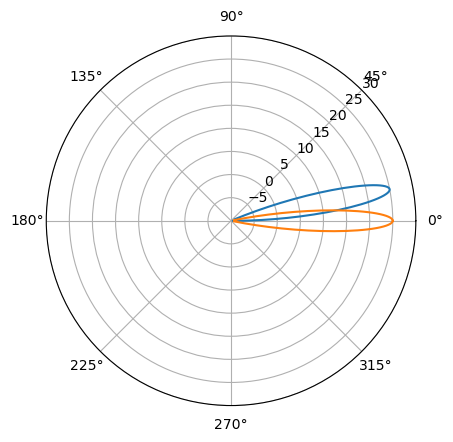

In [3]:
theta = np.linspace(0,2*np.pi,1000)
AL = m.array.ant_left.main_lobe_approx_narrow(theta-np.pi/16)
AM = m.array.ant_middle.main_lobe_approx_narrow(theta)

fig = plt.figure()
ax = plt.subplot(projection="polar")

ax.set_rlabel_position(45)
ax.set_rlim(-10,30)
ax.plot(theta, AL)
ax.plot(theta, AM)

As you can probably tell, this is a massive over-simplification of how the antennas' gains look like in real life, but it helps illustrate a point. There is an obvious beam where these antenna are pointing, this is where the antenna are essentially effective. There is a relationship between the two patterns, for example if a sample gives AL = 25 and AM = 0, we know the sample must be taken somewhere in the +ve $\theta$ direction. 

The gain is something we can measure really easily. The gain of one antenna on it's own doesn't tell us much, but the gain of two antenna relative to each other give us a lot more information. Theoretically the angle of where a sample is taken is encoded within the recorded strengths of the antenna.

Because we are measuring in dB, the relative strengths of the antenna compared to each other will always be the same, i.e. the attenuation (signal lost) will be the same across each antenna, no matter how far away you are. $observed=true-a$, where a is attenuation. This doesn't take into account noise yet, we will come to that later.

In other words, the true gain (t) is only determined by the direction (angle) from the antenna. Graphs of true gain are shown above. The observed gain (s) is determined by the true gain minus attenuation.

Therefore
$$
    P(S|\theta,a) \sim N(\begin{bmatrix} s_1 \\ s_2 \\ s_3 \end{bmatrix}|\begin{bmatrix} t_1-a \\ t_2-a \\ t_3-a \end{bmatrix},b)
$$

Where $b$ is some independant noise, assumed to be gaussian.

We want to find: $p(\theta|s_1,s_2,s_3)$

So using bayes rule:

$$
    p(\theta|s_1,s_2,s_3) = \frac{p(s_1,s_2,s_3|\theta)p(\theta)}{p(s_1,s_2,s_3)}
$$

$p(\theta)$ is flat, as all angles are equally as likely as each other.

The likelihood $p(s_1,s_2,s_3|\theta)$ can be related back to above to attenuation x2. Meaning that it can be calculated numerically using an itergral:

$$
    p(S|\theta) = \int{}{} p(S|\theta, a)p(a) \, da
$$

As we noticed earlier $p(a)$ is uniform over $\R$, meaning it vanishes due to it being an improper prior.

Keep this in mind as I now explain something that is decently hard to get your head around.

Taking just our 2 antenna AL, AM, we can plot their strengths against each other, i.e. when AL is at x AM is at a,b,c,d..., and this gives us this function:

Text(0, 0.5, 'Gain AM (db)')

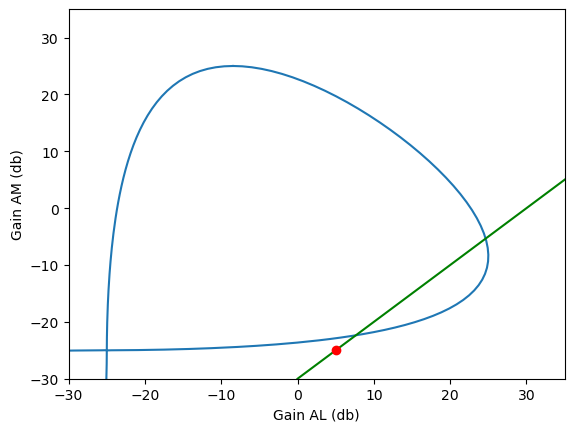

In [4]:
fig = plt.figure()
ax = plt.subplot()

ax.plot(AL, AM)
ax.plot([0,40],[-30,10], 'g')
ax.plot(5,-25,'or')
ax.set_ylim(-30,35)
ax.set_xlim(-30,35)
ax.set_xlabel("Gain AL (db)")
ax.set_ylabel("Gain AM (db)")



So how does this help us? Well considering that attenuation will stay constant for each antenna no matter the distance, this function will hold true no matter the distance (until we start to lose packets), the only thing that changes is that this function will be moved along the vector $\begin{bmatrix} 1 \\ 1 \end{bmatrix}$ for our 2-antenna setup.

Therefore, given a noiseless sample, we can plot the sample then move in the $\begin{bmatrix} 1 \\ 1 \end{bmatrix}$ direction until we intersect with the "true gain" graph above, and this will be our angle actual angle. Obviously we could intersect with multiple points of the function due to symmetry.

The red dot repersents a sample, the green line is the vector that passes in the direction $\begin{bmatrix} 1 \\ 1 \end{bmatrix}$. This sample gives 2 possible 'true' gain pairs.

With the addition of noise, it would be more helpful to think of the true values as the same function as before, but with with a gaussian error in each direction.

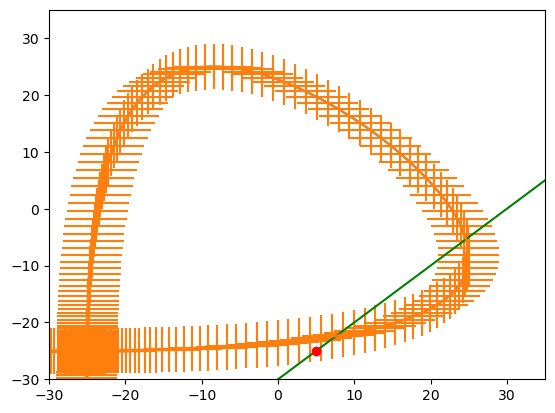

In [5]:
fig = plt.figure()
ax = plt.subplot()
ax.set_ylim(-30,35)
ax.set_xlim(-30,35)
ax.plot(AL, AM)

ax.errorbar(AL,AM,4,4)
ax.plot([0,40],[-30,10], 'g')
ax.plot(5,-25,'or')

This graph shows the same function but with error bars at $\pm4$ in both antenna, representing the 1st standard deviation of the model. You can now see that a recorded sample comtains a lot more error in it's projection. There is now a distribution of angles the red sample leads to if you take it back to the true gain graph.

This is where we can use the inference from earlier in a more intuitive way.

For each theta we get $t_1 = g_l(\theta), t_2 = g_r(\theta)$ as the true values. Then for each of these we compute the distance from $S$ to the vector (v) that passes through $t_1, t_2$ in direction $\begin{bmatrix} 1 \\ 1 \end{bmatrix}$. We then use this distance (d) to compute the univariate normal density, with mean of zero.

$$
    N(d|0,b^2)
$$

This means that a smaller d will give a larger likelihood.

To compute the normal distance from $s$ to the vector $v$ we can do:

$$
    d = || \vec{v}(S-t(\theta))\times \vec{v} + t(\theta) - S  ||
$$

The algorithm in the `Model` class defines a search space of angles to some resolution and limiters. `search_angles` should be at high enough resolution that when passed through the AOA algorithm it gives us a useful estimate, but not too large so it takes a long time to calculate. Because of the nature of the problem, we can expect bees to be 30-800 meters away from the antenna. Any closer the receiver starts acting too erroneously due to the high power, and any further away we loose too many packets to make decent enough guesses.

Quantising the search space at the degree level, so 90 degrees between -45 and 45, means each degree has an error of $\pm0.5 \deg$, which at 400m is $\pm 3m$ and at 800m $\pm 6m$.

If we do this over each angle, then use the normal distribution, we get a pdf value for each angle. Then normalising over $\theta$ we get a probability density over all angles for each S. We can then plot this for an actual sample like this:

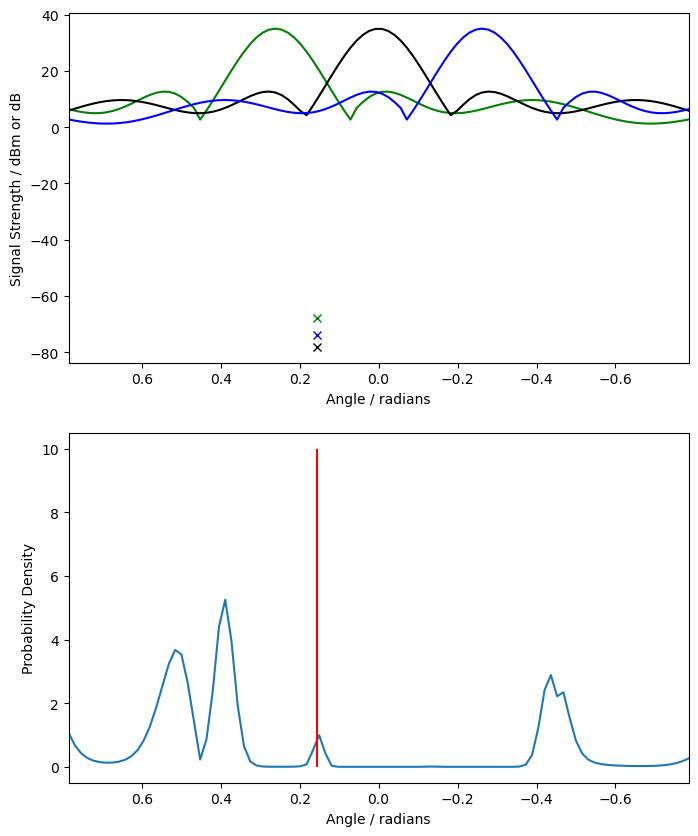

In [6]:
m.plot_estimation_vectors(-np.pi/4,np.pi/4)

In the top half of the figure the true gain (t) pattern of the 3 antenna is shown, S, the observed noisy sample, is plotted below t. In the lower half the generated Probability Density function is shown, the red line is the true angle for reference.

What we see here is that this theta is particulary good at generating a pretty narrow PDF, meaning that when we come to estimate the angle later, the system in it's current setup will be more accurate around this theta. However can assume that there will be values of $\theta$ that are not so good:

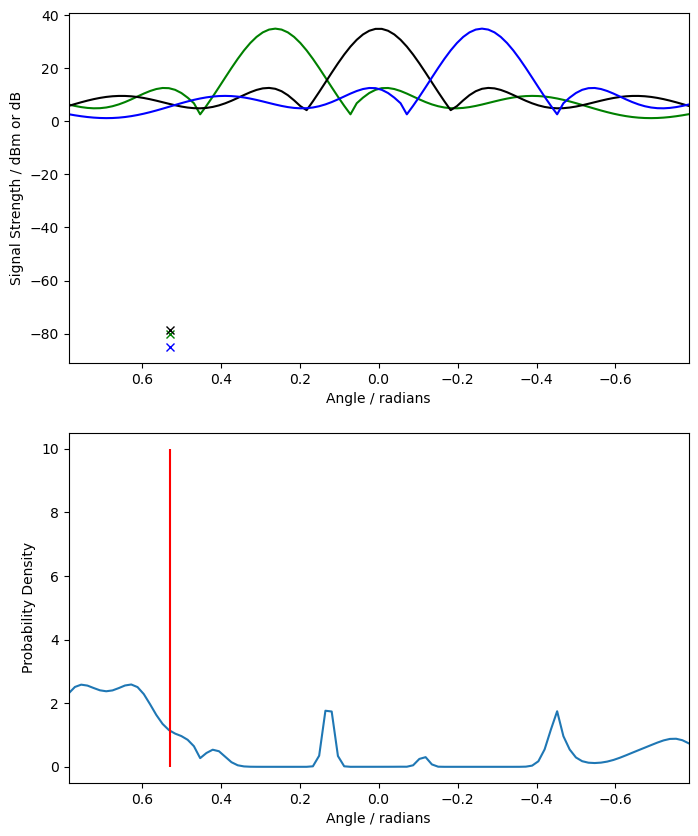

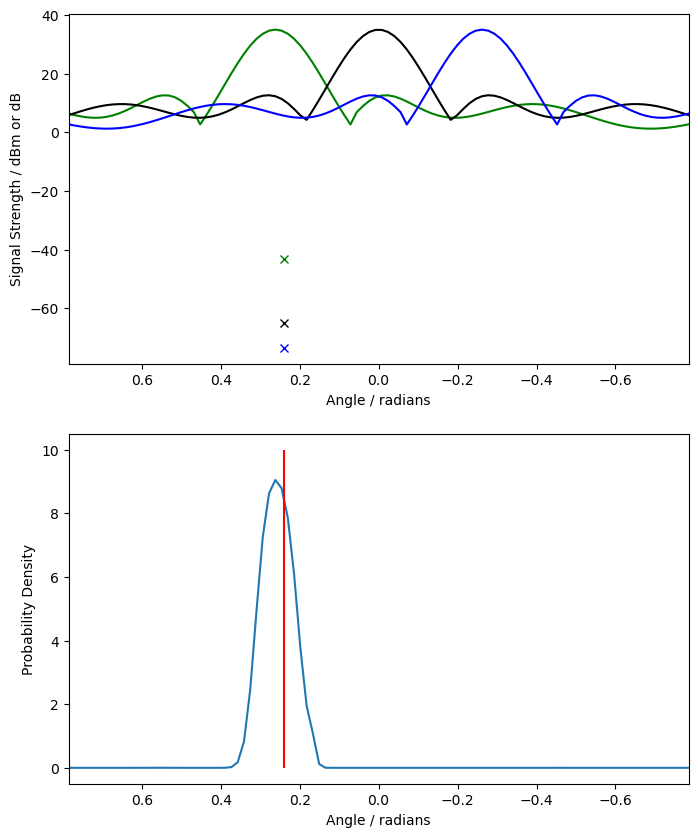

In [7]:
m.set_random_reciever()
m.plot_estimation_vectors(-np.pi/4,np.pi/4)
m.set_random_reciever()
m.plot_estimation_vectors(-np.pi/4,np.pi/4)

In the first figure, although $\theta$ has only changed by ~0.1, a mix of the sample noise being different and the true gain pattern not being unique, has led to 3 equally-as likely spikes in the PDF.

The next figure shows that even in the messy side lobes, information can be obtained from the sampled values, as a decently probable peak exists where the true angle lays.

Running many tests the potential of this system is apparent. Due to the nature of the bee flight inference system being developed by PHD, even samples that produce pretty wide or messy PDFs can be useful due to particle / kalman filtering.

Parsing this data into vectors the bee lies upon isn't as simple as taking the most probable values, because in a lot of cases a massive peak exists while the peak where $\theta$ lies is somewhere else and much smaller. Taking the angles where the N highest peaks exist is the most straightforward solution. Luckily scipy.stats has a function that does exactly this. What we can then generate are multiple vectors the reciever could lie on

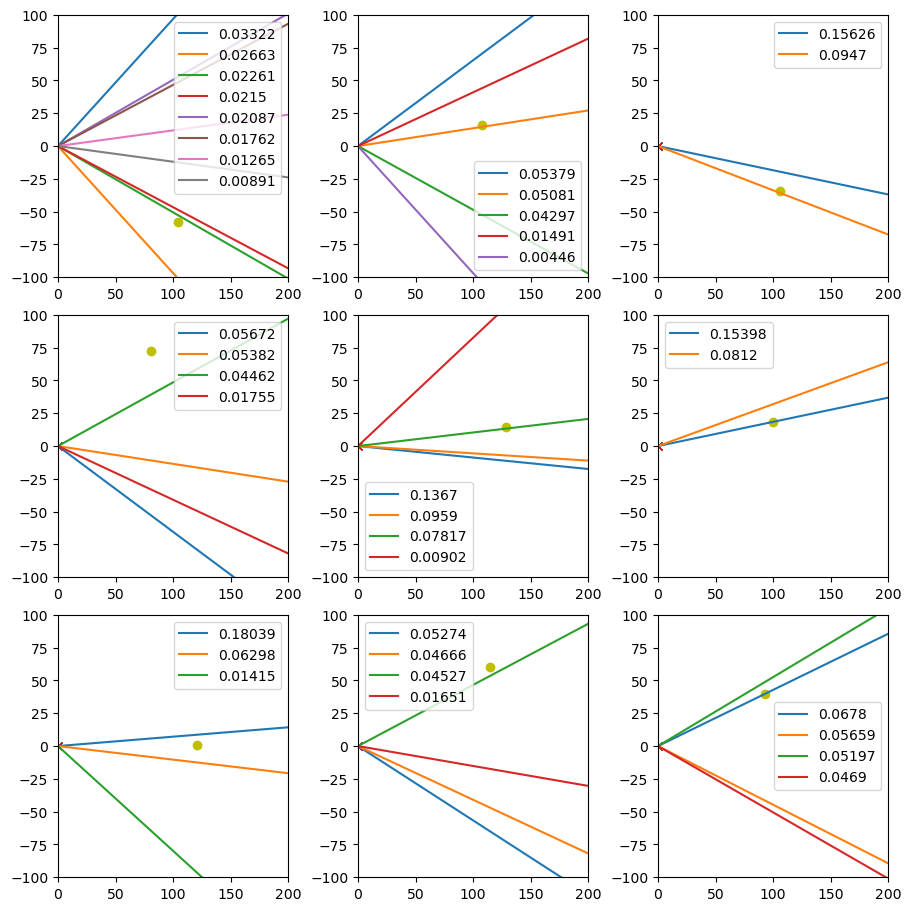

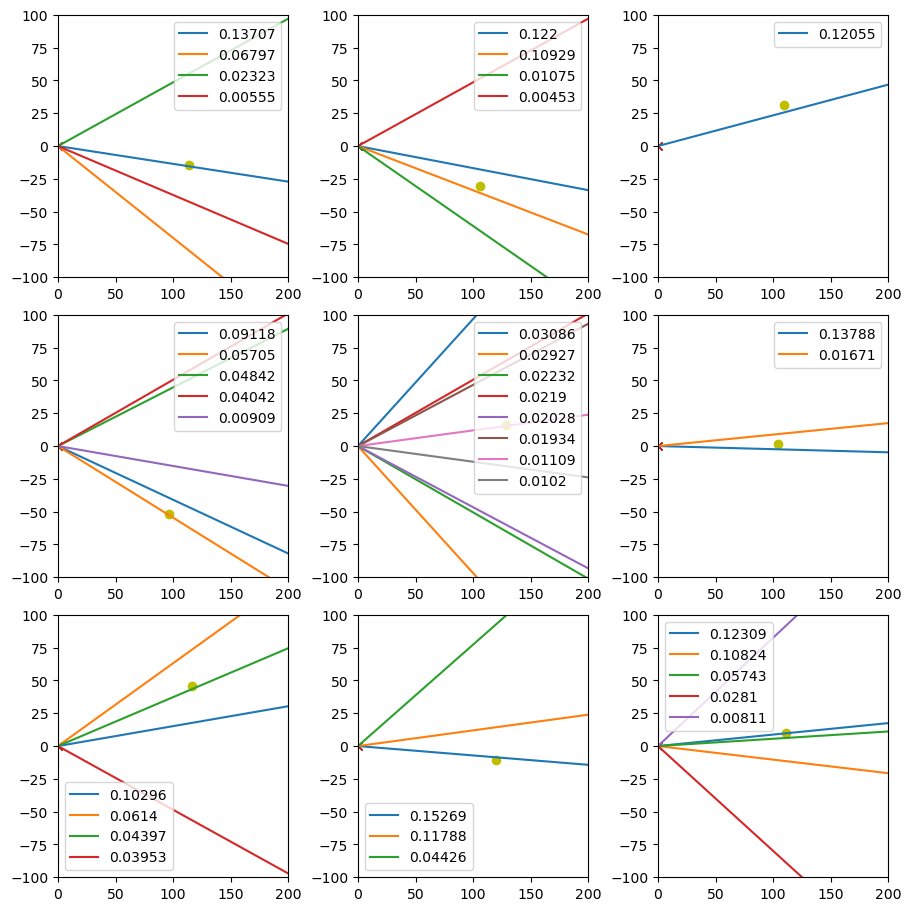

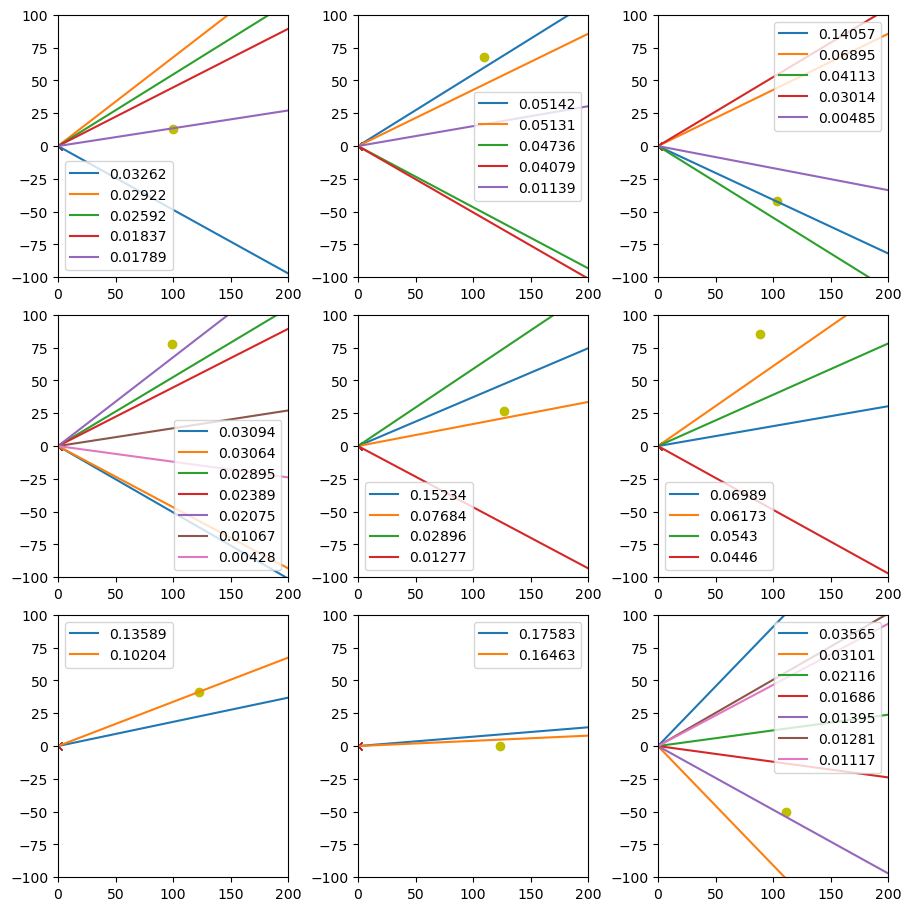

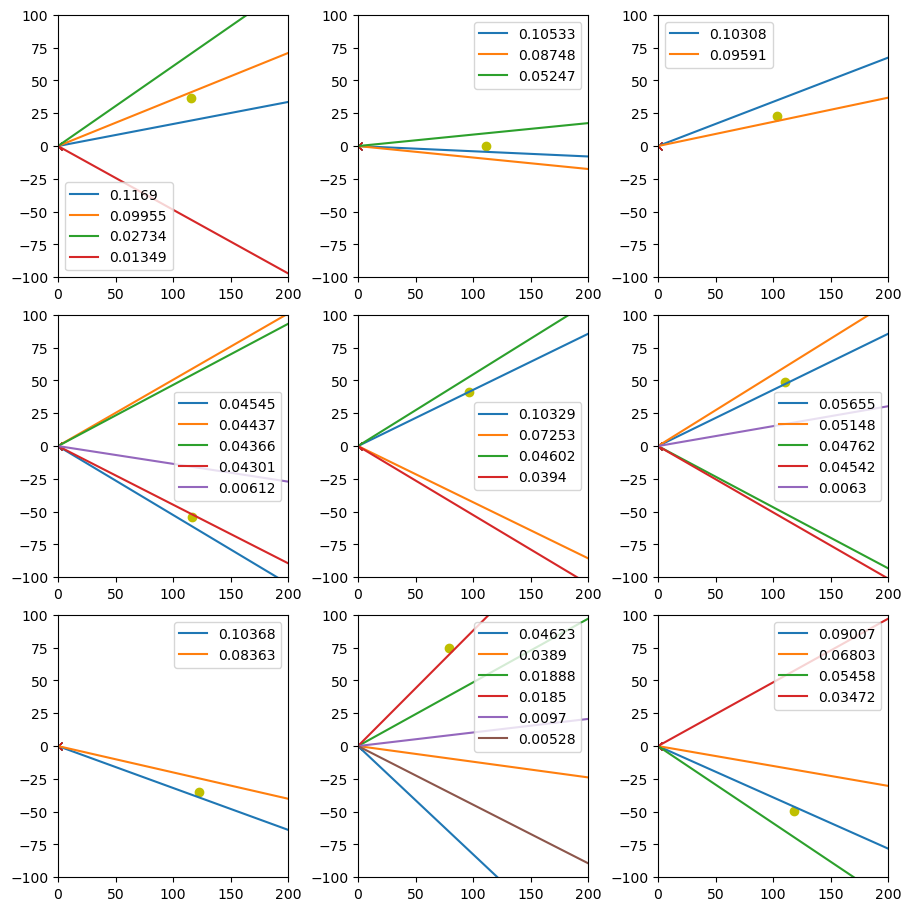

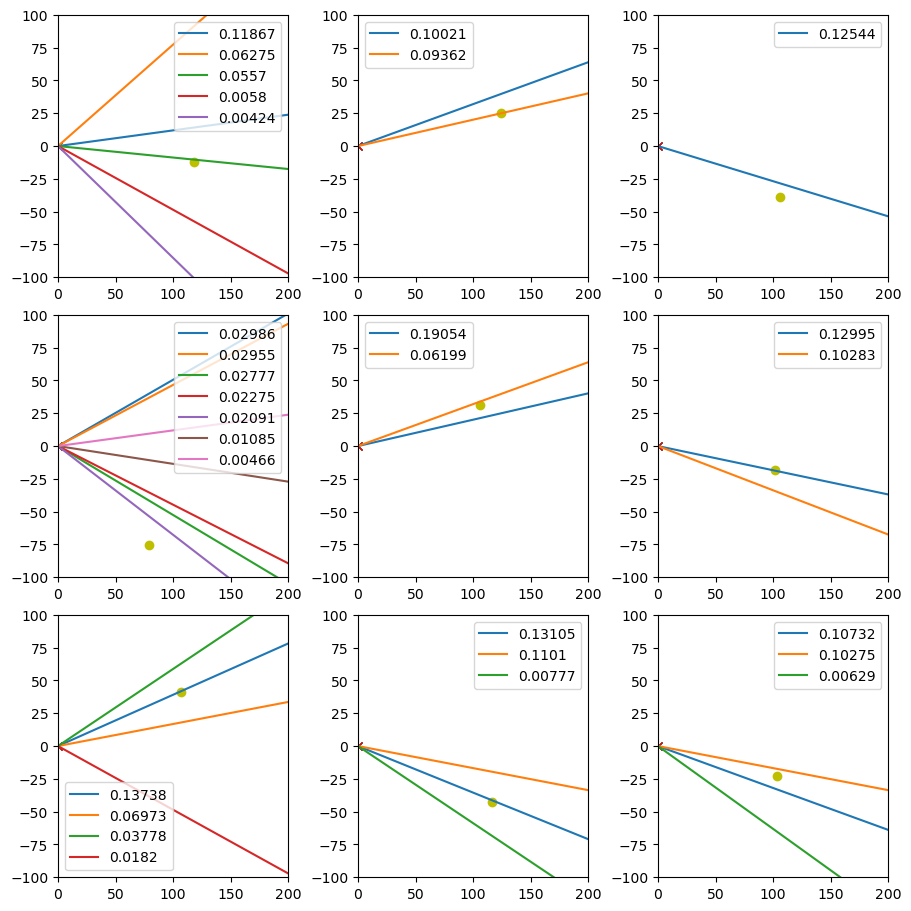

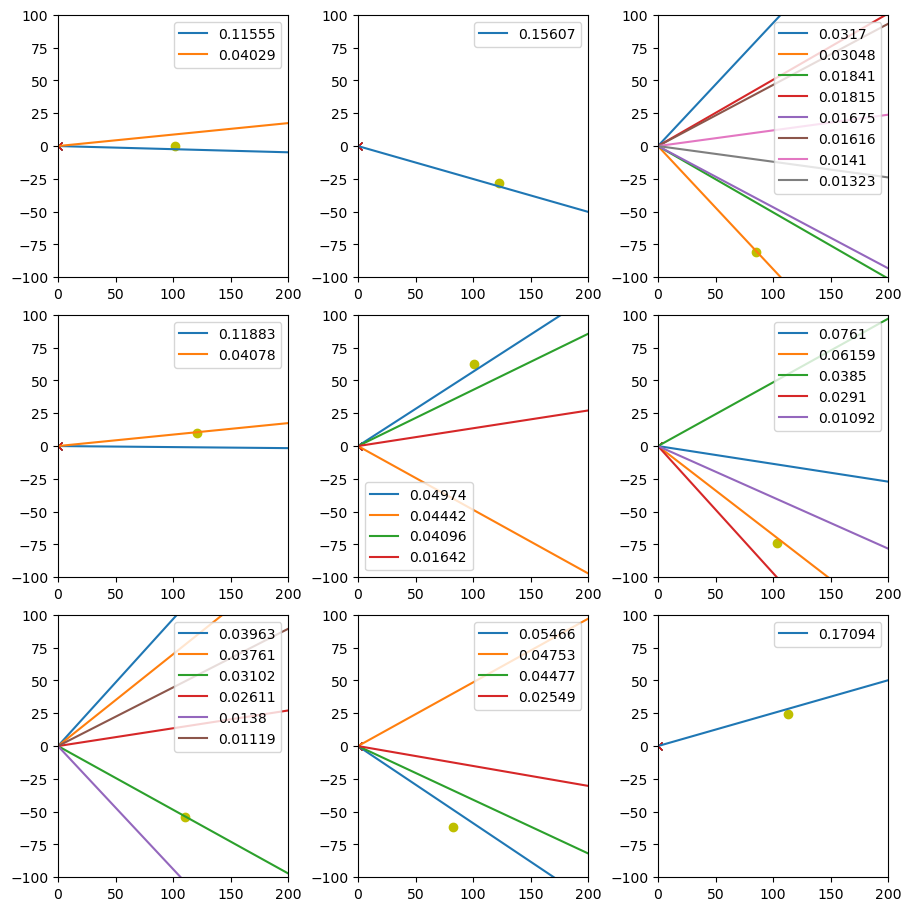

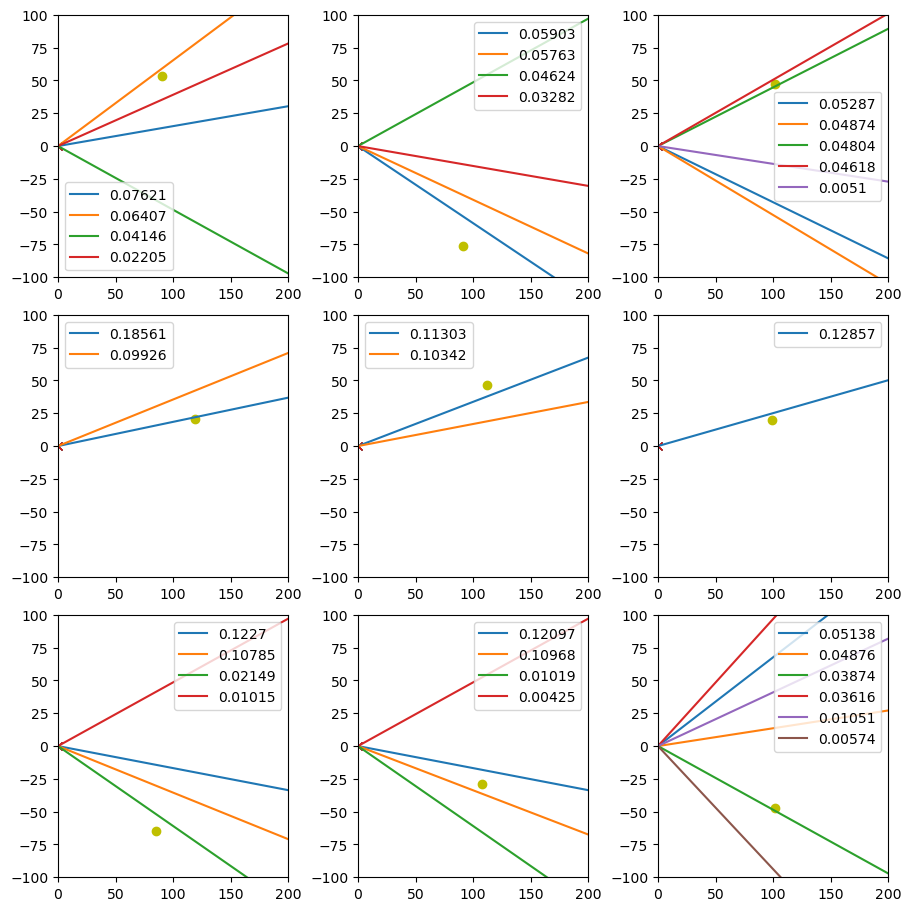

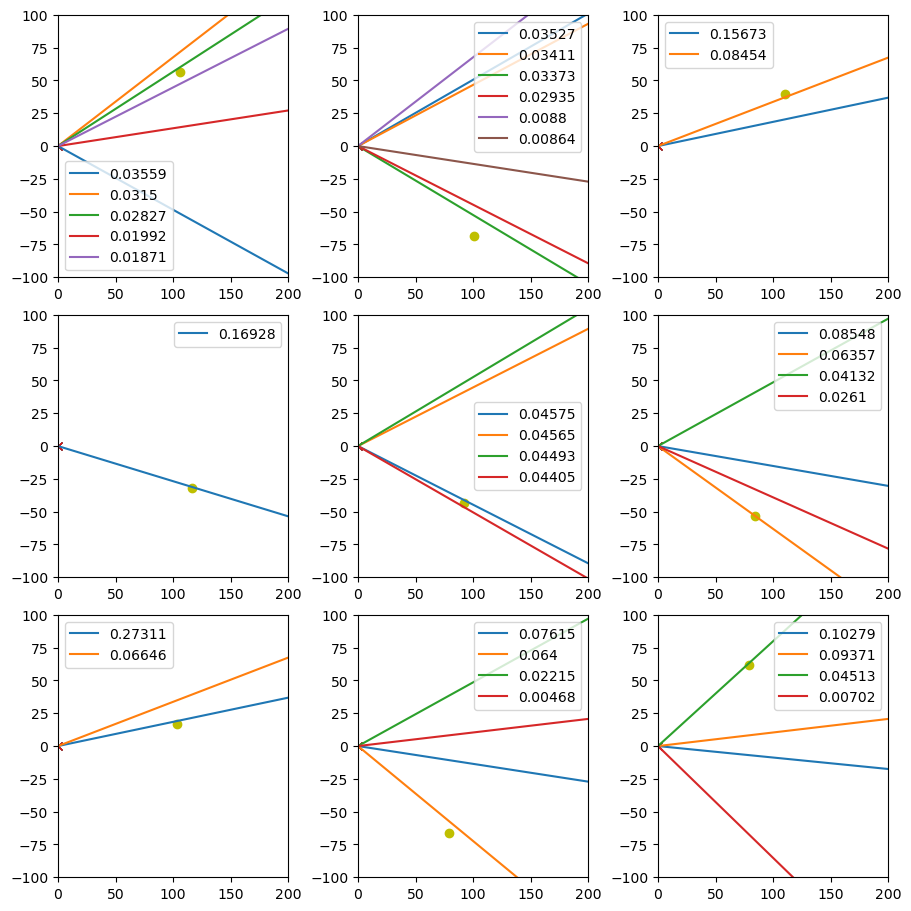

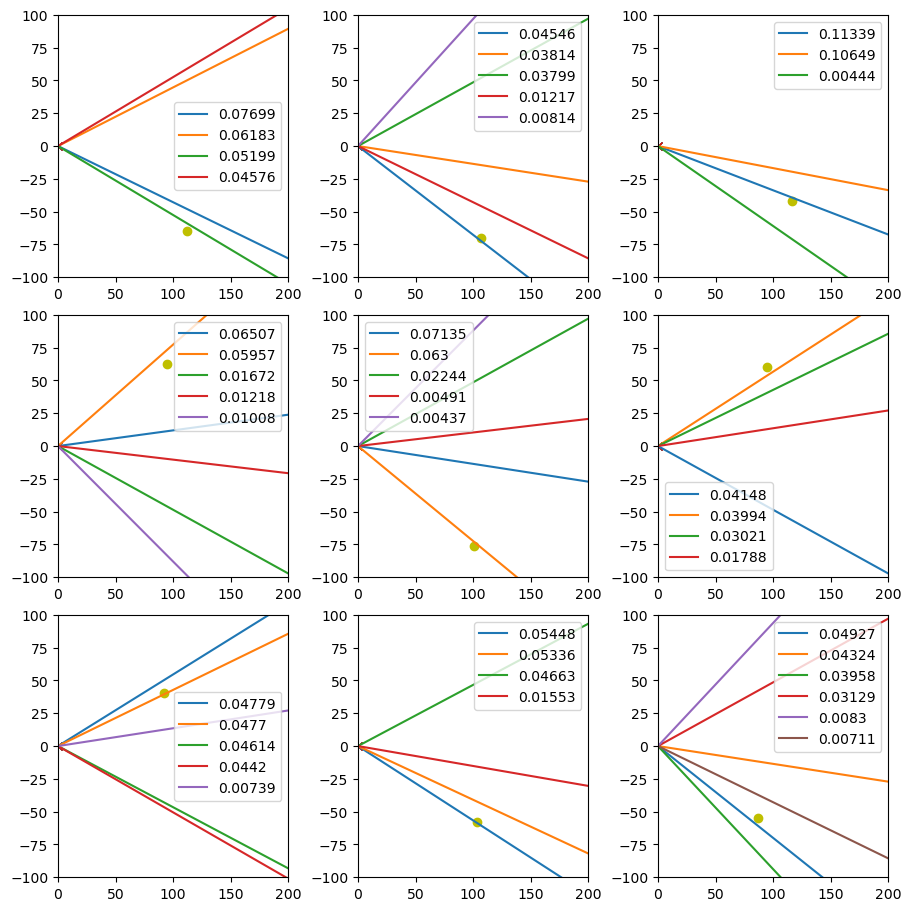

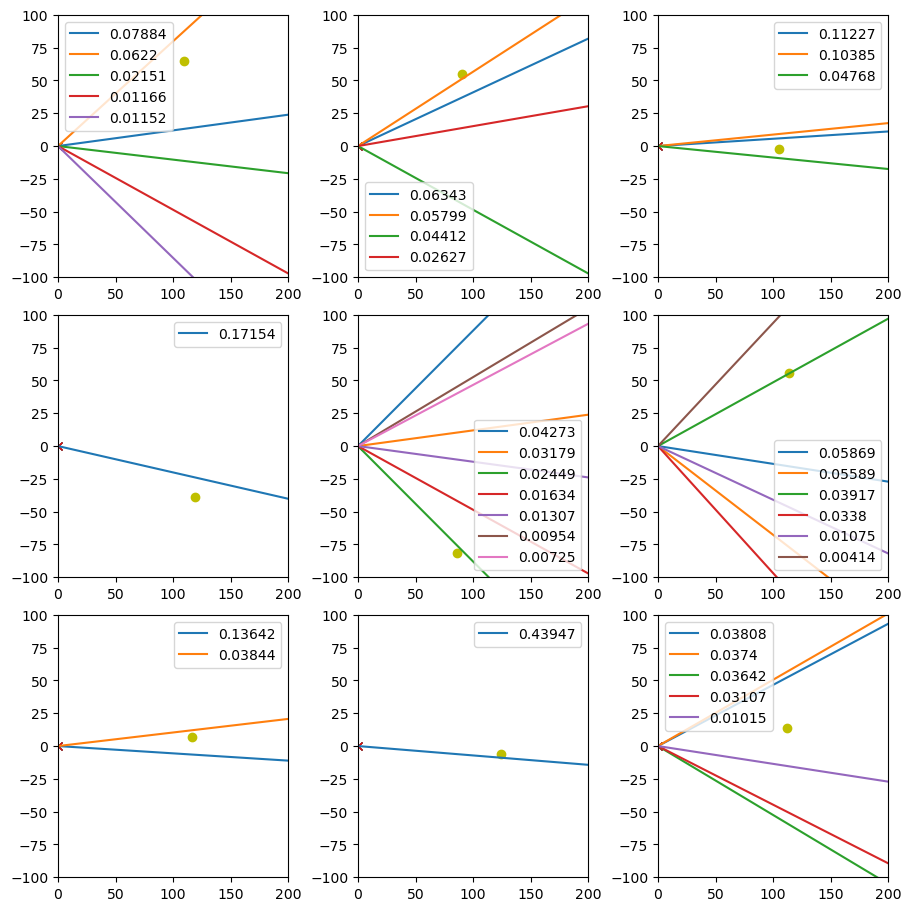

In [8]:


for i in range(10):
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(9, 9),
                            layout="constrained")
    # add an artist, in this case a nice label in the middle...

    for row in range(3):
        for col in range(3):
            m.set_random_reciever(dlow=100,dhigh=130)
            axs[row,col].set_xlim(0,200)
            axs[row,col].set_ylim(-100,100)
            m.spatial_plot(axs[row,col])

What do these show?
Why are they helpful for my project...

Choosing the estimate angle:
Another way we could estimate the angle is by using the PDF to inform a random choice on the search angles

## Optimisation and Testing

Now we have the means for AOA estimation we need to find a way to evaluate the setup's accuracy. Once we have done this we can evaluate and compare a number of samples, theoretically finding the best setup for our use case.

First though we need to determine what our idea of a 'successful' estimate is.